In [10]:
from disk_utils_jax import jax_model
from regression import log_likelihood, log_likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np

jax.config.update("jax_enable_x64", True)

## Defining Disk and SPF Parameters

In [11]:
disk_params1 = {}
disk_params1['inclination'] = 60. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [12]:
disk_params2 = {}
disk_params2['inclination'] = 40. #In degrees
disk_params2['position_angle'] = 30. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [13]:
# Scattering Phase Function Parameters
spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

## Creating Disk Models

In [14]:
# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params={'g1': 0.9, 'g2': -0.2, 'weight': 0.7})
end = datetime.now()
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params2,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

0:00:00.003346
0:00:00.001850


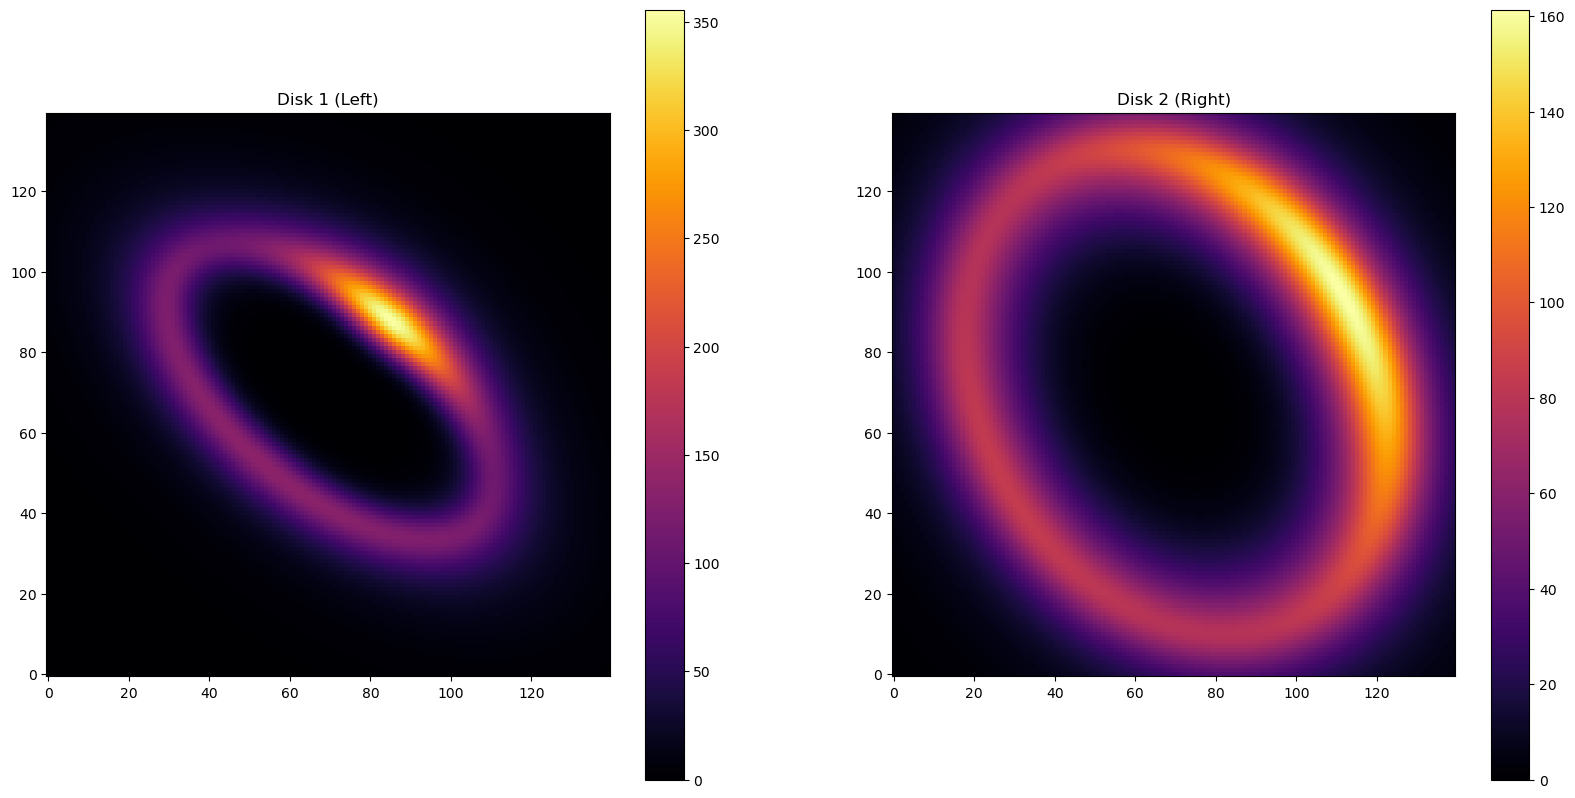

In [15]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0].set_title("Disk 1 (Left)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1].set_title("Disk 2 (Right)")
plt.colorbar(im,ax=axes[1])

## Timing Model Methods

In [16]:
def test():
    jax_model(DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params1, {'g': 0.3})

%timeit test()

1.3 ms ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
#def test():
#    jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
#                              spf_params={'g1': 0.9, 'g2': -0.2, 'weight': 0.7})

#%timeit test

## Add Noise

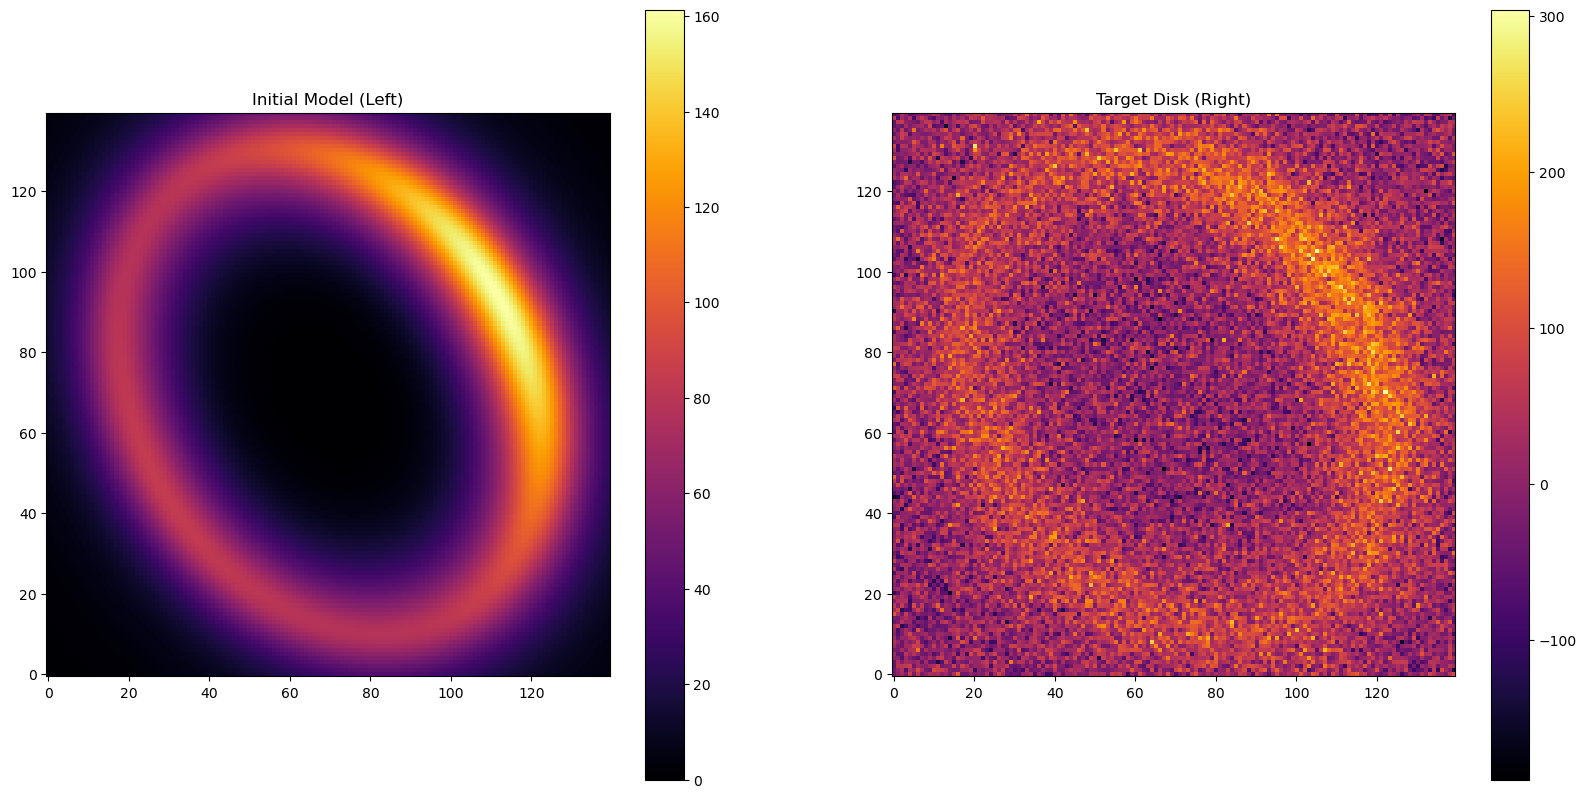

In [18]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image1.shape)

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0].set_title("Initial Model (Left)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk (Right)")
plt.colorbar(im,ax=axes[1])

## Log-Likelihood Testing

In [19]:
ll2 = log_likelihood(DustEllipticalDistribution2PowerLaws,DoubleHenyeyGreenstein_SPF,disk_params2,spf_params,disk_image2+noise,
           np.ones(disk_image2.shape)*noise_level)
ll1 = log_likelihood(DustEllipticalDistribution2PowerLaws,DoubleHenyeyGreenstein_SPF,disk_params1,spf_params,disk_image2+noise,
           np.ones(disk_image2.shape)*noise_level)

print("Log-Likelihood of disk 2 model: {x}".format(x=ll2))
print("Log-Likelihood of disk 1 model: {x}".format(x=ll1))

Log-Likelihood of disk 2 model: -86517.61825492795
Log-Likelihood of disk 1 model: -135468.08076889702


## Testing Jax Grad with Log-Likelihood Method

In [20]:
jax.config.update("jax_debug_nans", False)

ll_grad_func = jax.grad(log_likelihood, argnums=(2,3))
print(ll_grad_func(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params1, spf_params, disk_image2+noise, np.ones(disk_image2.shape)*noise_level))

({'alpha_in': Array(2949.59130449, dtype=float64, weak_type=True), 'alpha_out': Array(-4330.56711844, dtype=float64, weak_type=True), 'flux_scaling': Array(-0.09200092, dtype=float64, weak_type=True), 'inclination': Array(-3657.74785266, dtype=float64, weak_type=True), 'position_angle': Array(76.96405002, dtype=float64, weak_type=True), 'sma': Array(4589.51855797, dtype=float64, weak_type=True)}, {'g1': Array(-31419.42005581, dtype=float64, weak_type=True), 'g2': Array(-5896.67327553, dtype=float64, weak_type=True), 'weight': Array(-48668.92294376, dtype=float64, weak_type=True)})


## Testing Scipy-Optimize Minimize with Log-Likelihood

In [21]:
import numpy as np

def convert_to_dict(disk_params, flux_scaling=1e6):
    disk_dict = {}
    disk_dict['inclination'] = disk_params[3]
    disk_dict['position_angle'] = disk_params[4]
    disk_dict['alpha_in'] = disk_params[0]
    disk_dict['alpha_out'] = disk_params[1]
    disk_dict['flux_scaling'] = flux_scaling
    disk_dict['sma'] = disk_params[2]
    return disk_dict

# using disk 1 params as initial parameters
disk_params_1d = np.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

In [22]:
# comparing disk 1 model to the disk 2 noise model
print(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params1, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level))

# comparing disk 2 model to the disk 2 noise model
print(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level))

135468.08076889702
86517.61825492795


In [23]:
# JIT compiling likelihood-1d method

log_likelihood_1d(disk_params_1d, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params, disk_params2["flux_scaling"],
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

def test():
    log_likelihood_1d(disk_params_1d, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params, disk_params2["flux_scaling"],
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)
%timeit test()

1.57 ms ± 424 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Optimizing Disk with Nelder-Mead Method (Doesn't Require Gradient)

In [24]:
from scipy.optimize import minimize
from jaxopt import ScipyMinimize
from jaxopt import ScipyBoundedMinimize
from jaxopt import BFGS

In [25]:
ll = lambda *args: -log_likelihood_1d(*args)
no_grad_method = "Nelder-Mead"

start = datetime.now()
soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method = no_grad_method)
end = datetime.now()
print(end-start)

disk_fit_nm = convert_to_dict(soln.x)

0:00:00.931517


### Optimizing Disk with Gradient

In [26]:

ll = lambda *args: -log_likelihood_1d(*args)

start = datetime.now()
soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method=None)
end = datetime.now()
print(end-start)

disk_fit_grad = convert_to_dict(soln.x)

0:00:00.680244


### Optimizing Disk with JAXopt

In [27]:
from regression import log_likelihood_1d_pos

# using a jax array instead of a numpy array
disk_params_1d_jax = jnp.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

log_likelihood_1d_pos(disk_params_1d_jax, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params, disk_params2["flux_scaling"],
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

Array(135468.0807689, dtype=float64)

In [28]:
#llgf = lambda x: jax.grad(log_likelihood_1d_pos(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
#                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level), argnums=0)

ll = lambda x: log_likelihood_1d_pos(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

start = datetime.now()
solver = ScipyMinimize(fun=ll,  method="l-bfgs-b", maxiter=500, jit=False)
res = solver.run(init_params=disk_params_1d_jax)
#solver = ScipyBoundedMinimize(fun=ll, method="l-bfgs-b",maxiter=500,jit=False)
#res = solver.run(init_params=disk_params_1d_jax, bounds=([1, -10, 0, 0, 0], [10, -1, 80, 90, 90]))
end = datetime.now()
print(end-start)

params, states = res
print(params)

0:00:25.781079
[ 5.04932247 -6.91148885 40.00312236 40.08799536 30.50774498]


In [29]:
disk_fit_jaxopt = convert_to_dict(params)

## Displaying Scipy Fit Model Results

In [30]:
# Lower Likelihood means better fit

print("Nelder-Mead Optimization Disk Parameters: " + str(disk_fit_nm))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_fit_nm, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Gradient Optimization Disk Parameters: " + str(disk_fit_grad))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_fit_grad, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("JAX Optimization Disk Parameters: " + str(disk_fit_jaxopt))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_fit_jaxopt, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

Nelder-Mead Optimization Disk Parameters: {'inclination': 40.08794769600168, 'position_angle': 30.507917937578338, 'alpha_in': 5.049314720336414, 'alpha_out': -6.911477336175201, 'flux_scaling': 1000000.0, 'sma': 40.00308969576645}
Log-Likelihood: 86516.61714315522
Gradient Optimization Disk Parameters: {'inclination': 40.088266613087285, 'position_angle': 30.474156108088206, 'alpha_in': 5.049211667570768, 'alpha_out': -6.911298872069308, 'flux_scaling': 1000000.0, 'sma': 40.003385251972496}
Log-Likelihood: 86516.61970725114
JAX Optimization Disk Parameters: {'inclination': Array(40.08799536, dtype=float64), 'position_angle': Array(30.50774498, dtype=float64), 'alpha_in': Array(5.04932247, dtype=float64), 'alpha_out': Array(-6.91148885, dtype=float64), 'flux_scaling': 1000000.0, 'sma': Array(40.00312236, dtype=float64)}
Log-Likelihood: 86516.61714315662
Actual Disk Parameters: {'inclination': 40.0, 'position_angle': 30.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, '

In [31]:
start = datetime.now()
disk_image_fit_nm = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_nm,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
disk_image_fit_grad = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_grad,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
disk_image_fit_jaxopt = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_jaxopt,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

0:00:05.586678


Text(0.5, 1.0, 'Target Disk (Right)')

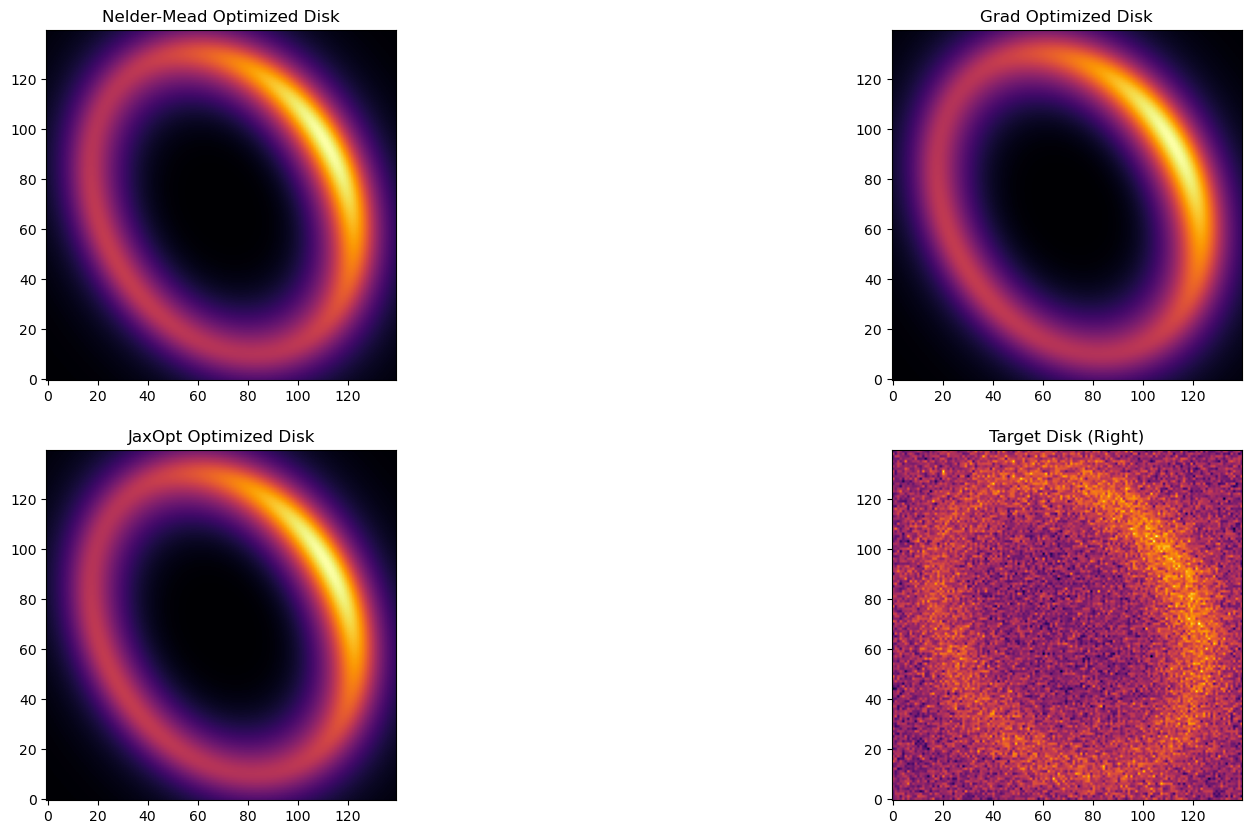

In [32]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

axes[0][0].imshow(disk_image_fit_nm, origin='lower', cmap='inferno')
axes[0][0].set_title("Nelder-Mead Optimized Disk")

axes[0][1].imshow(disk_image_fit_grad, origin='lower', cmap='inferno')
axes[0][1].set_title("Grad Optimized Disk")

axes[1][0].imshow(disk_image_fit_jaxopt, origin='lower', cmap='inferno')
axes[1][0].set_title("JaxOpt Optimized Disk")

axes[1][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[1][1].set_title("Target Disk (Right)")

### More Precise Testing on Scipy Optimization Method Runtimes

In [33]:
ll = lambda *args: -log_likelihood_1d(*args)
llp = lambda x: log_likelihood_1d_pos(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

def nelder_mead_test():
    soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method="nelder-mead")
    
def gradient_optimization_test():
    soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method=None)
    
def jax_optimization_test():
    solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
    res = solver.run(init_params=disk_params_1d_jax)
    #solver = ScipyBoundedMinimize(fun=llp, method="l-bfgs-b",maxiter=500,jit=False)
    #res = solver.run(init_params=disk_params_1d_jax, bounds=([1, -10, 0, 0, 0], [10, -1, 80, 90, 90]))

In [34]:
%timeit nelder_mead_test()
%timeit gradient_optimization_test()
%timeit jax_optimization_test()

913 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
645 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.58 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Running Optimizations with more Parameters

In [35]:
disk_params_1d_jax = jnp.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

# initial spf params, 0: g1, 1: g2, 2: weight
spf_params_jax = jnp.array([0.5, -0.4, 0.6])

all_pars = jnp.concatenate((disk_params_1d_jax, spf_params_jax))
print(all_pars)

[ 8.  -5.  30.  60.  50.   0.5 -0.4  0.6]


In [36]:
from regression import log_likelihood_1d_pos_all_pars

# If nans are seen, Jax Opt won't work
llp = lambda x: log_likelihood_1d_pos_all_pars(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

jax.config.update("jax_debug_nans", True)

grad_func = jax.grad(llp, argnums=(0))

print(grad_func(all_pars))

jax.config.update("jax_debug_nans", False)

[-2702.23447265  3744.34242539 -4290.09307888  3303.75860945
   -77.67620373 17613.10385701 -3916.16357616 25482.86704398]


In [37]:
no_grad_method = "Nelder-Mead"
soln_nm = minimize(llp, all_pars, method=no_grad_method)
disk_fit_nm = convert_to_dict(soln_nm.x)

soln_go = minimize(llp, all_pars, method = None)
disk_fit_go = convert_to_dict(soln_go.x)

#solver = ScipyBoundedMinimize(fun=llp, method="l-bfgs-b",maxiter=500,jit=False)
#soln_sm, ignore = solver.run(init_params=all_pars, bounds=([1, -10, 0, 0, 0, 0.05, -0.95, 0.05],
#                                                           [10, -1, 80, 90, 90, 0.95, -0.05, 0.95]))

solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
soln_sm, ignore = solver.run(init_params=all_pars)

#solver = BFGS(fun=llp, maxiter=500, jit=False)
#soln_sm, ignore = solver.run(init_params=all_pars)

#print(soln_nm)
print(soln_go)
#print(soln_sm)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 86514.36050742024
        x: [ 5.050e+00 -6.888e+00  4.002e+01  4.017e+01  3.054e+01
             4.788e-01 -3.820e-01  7.095e-01]
      nit: 98
      jac: [ 0.000e+00  9.766e-04  9.766e-04  0.000e+00  9.766e-04
             0.000e+00  0.000e+00  1.953e-03]
 hess_inv: [[ 2.205e-01 -8.122e-02 ... -3.079e-01  5.745e-02]
            [-8.122e-02  4.241e-02 ...  1.167e-01 -2.191e-02]
            ...
            [-3.079e-01  1.167e-01 ...  4.428e-01 -8.258e-02]
            [ 5.745e-02 -2.191e-02 ... -8.258e-02  1.545e-02]]
     nfev: 1494
     njev: 166


### Likelihood Results

In [38]:
# Lower Likelihood means better fit

print("Nelder-Mead Optimization Disk Parameters: " + str(disk_fit_nm) + str(DoubleHenyeyGreenstein_SPF.unpack_pars(soln_nm.x[5:])))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars(soln_nm.x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Gradient Optimization Disk Parameters: " + str(disk_fit_grad) + str(DoubleHenyeyGreenstein_SPF.unpack_pars(soln_go.x[5:])))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars(soln_go.x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("JAX Optimization Disk Parameters: " + str(disk_fit_jaxopt) + str(DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars(soln_sm, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2) + str(spf_params))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

Nelder-Mead Optimization Disk Parameters: {'inclination': 40.17139734763845, 'position_angle': 30.538420391130828, 'alpha_in': 5.04987714412799, 'alpha_out': -6.8880827489331224, 'flux_scaling': 1000000.0, 'sma': 40.01995099645717}{'g1': Array(0.4787809, dtype=float64), 'g2': Array(-0.38201388, dtype=float64), 'weight': Array(0.70945313, dtype=float64)}
Log-Likelihood: 86514.3605086718
Gradient Optimization Disk Parameters: {'inclination': 40.088266613087285, 'position_angle': 30.474156108088206, 'alpha_in': 5.049211667570768, 'alpha_out': -6.911298872069308, 'flux_scaling': 1000000.0, 'sma': 40.003385251972496}{'g1': Array(0.47879023, dtype=float64), 'g2': Array(-0.38197904, dtype=float64), 'weight': Array(0.70945169, dtype=float64)}
Log-Likelihood: 86514.36050742024
JAX Optimization Disk Parameters: {'inclination': Array(40.08799536, dtype=float64), 'position_angle': Array(30.50774498, dtype=float64), 'alpha_in': Array(5.04932247, dtype=float64), 'alpha_out': Array(-6.91148885, dtype

### Image Comparisions

In [39]:
disk_fit_nm = convert_to_dict(soln_nm.x[0:5])
spf_params_nm = DoubleHenyeyGreenstein_SPF.unpack_pars(soln_nm.x[5:])

disk_fit_go = convert_to_dict(soln_go.x[0:5])
spf_params_go = DoubleHenyeyGreenstein_SPF.unpack_pars(soln_go.x[5:])

disk_fit_jaxopt = convert_to_dict(soln_sm[0:5])
spf_params_jaxopt = DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])


sp = DoubleHenyeyGreenstein_SPF.unpack_pars(spf_params_jax)
disk_image1_ap = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1, spf_params=sp)

disk_image_fit_nm = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_nm,
                               spf_params=spf_params_nm)
disk_image_fit_go = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_go,
                               spf_params=spf_params_go)
disk_image_fit_jaxopt = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_jaxopt,
                               spf_params=spf_params_jaxopt)

Text(0.5, 1.0, 'JaxOpt Optimized Disk')

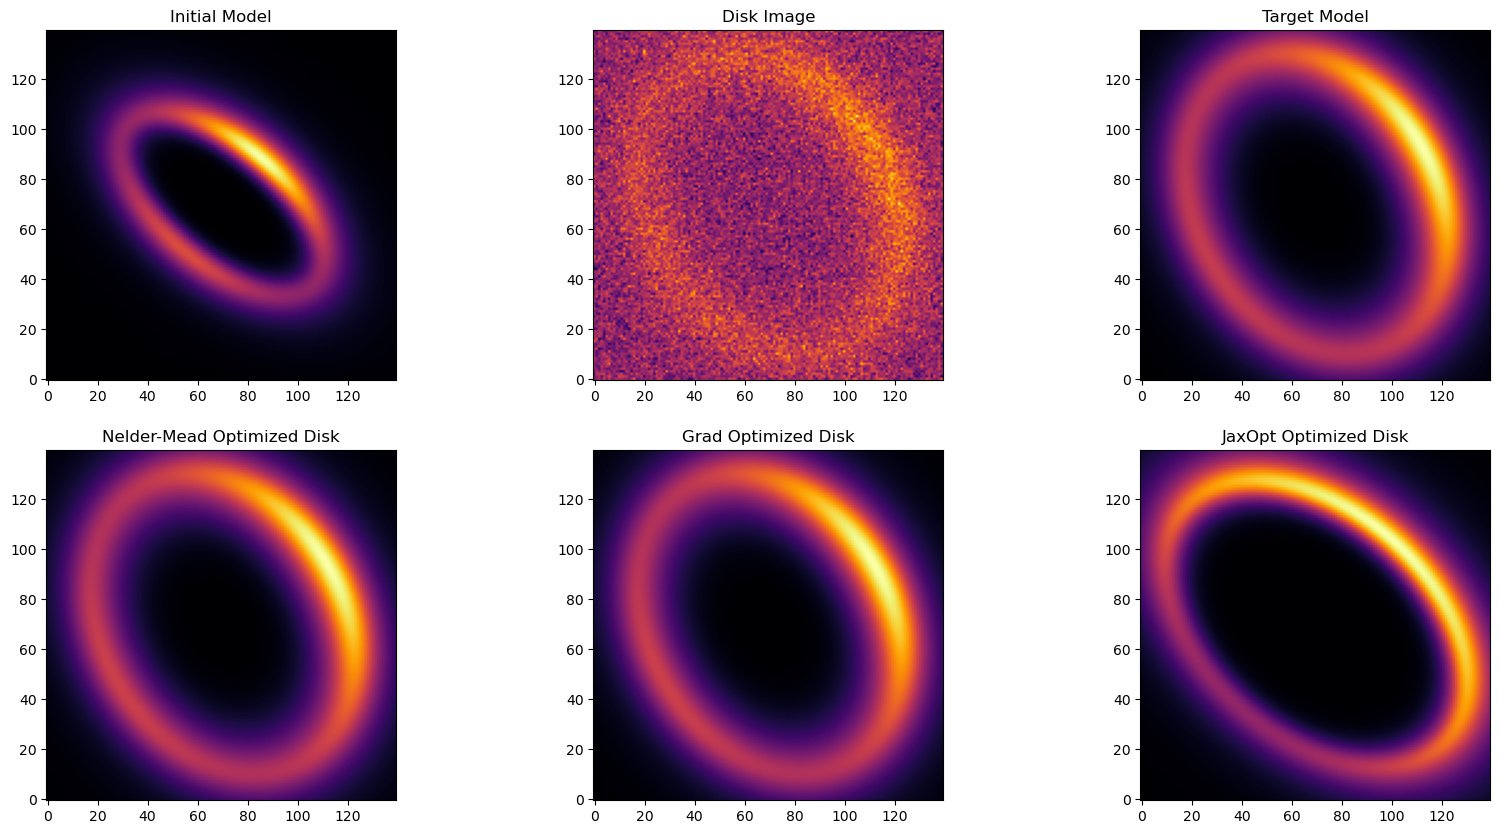

In [40]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

axes[0][0].imshow(disk_image1_ap, origin='lower', cmap='inferno')
axes[0][0].set_title("Initial Model")

axes[0][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[0][1].set_title("Disk Image")

axes[0][2].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0][2].set_title("Target Model")

axes[1][0].imshow(disk_image_fit_nm, origin='lower', cmap='inferno')
axes[1][0].set_title("Nelder-Mead Optimized Disk")

axes[1][1].imshow(disk_image_fit_go, origin='lower', cmap='inferno')
axes[1][1].set_title("Grad Optimized Disk")

axes[1][2].imshow(disk_image_fit_jaxopt, origin='lower', cmap='inferno')
axes[1][2].set_title("JaxOpt Optimized Disk")

In [41]:
def nelder_mead_test():
    soln = minimize(llp, all_pars, method="Nelder-Mead")
    
def gradient_optimization_test():
    soln = minimize(llp, all_pars, method=None)
    
#def jax_optimization_test():
#    res = solver.run(init_params=all_pars, bounds=([1, -10, 0, 0, 0, 0.05, -0.95, 0.05],
#                                                    [10, -1, 80, 90, 90, 0.95, -0.05, 0.95]))
    
norm_solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
#norm_solver = BFGS(fun=llp, maxiter=500, jit=False)
def jax_optimization_test_norm():
    res = norm_solver.run(init_params=all_pars)

#### Testing Runtimes

In [42]:
%timeit nelder_mead_test()
%timeit gradient_optimization_test()
#%timeit jax_optimization_test()
%timeit jax_optimization_test_norm()

3.84 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.58 s ± 96.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.25 s ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Plotting SPF vs Log-Likelihood

In [43]:
'''llspf1 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2['alpha_in'], disk_params2['alpha_out'], disk_params2['sma'], disk_params2['inclination'], 
                                                         disk_params2['position_angle'], x, -0.3, 0.7]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

llspf2 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2['alpha_in'], disk_params2['alpha_out'], disk_params2['sma'], disk_params2['inclination'], 
                                                         disk_params2['position_angle'], 0.5, x, 0.7]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

llspf3 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2['alpha_in'], disk_params2['alpha_out'], disk_params2['sma'], disk_params2['inclination'], 
                                                         disk_params2['position_angle'], 0.5, -0.3, x]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

all_pars = jnp.concatenate((disk_params_1d_jax, spf_params_jax))

vals = np.linspace(-1, 1, 40)
results = np.zeros(40)

for i in range(0, len(vals)):
    results[i] = llspf1(vals[i])

plt.xlabel("g1")
plt.ylabel("positive log-likelihood")
plt.plot(vals, results)
plt.show()

for i in range(0, len(vals)):
    results[i] = llspf2(vals[i])

plt.xlabel("g2")
plt.ylabel("positive log-likelihood")
plt.plot(vals, results)
plt.show()

for i in range(0, len(vals)):
    results[i] = llspf3(vals[i])

plt.xlabel("weight")
plt.ylabel("positive log-likelihood")
plt.plot(vals, results)
plt.show()'''

'llspf1 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2[\'alpha_in\'], disk_params2[\'alpha_out\'], disk_params2[\'sma\'], disk_params2[\'inclination\'], \n                                                         disk_params2[\'position_angle\'], x, -0.3, 0.7]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,\n                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)\n\nllspf2 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2[\'alpha_in\'], disk_params2[\'alpha_out\'], disk_params2[\'sma\'], disk_params2[\'inclination\'], \n                                                         disk_params2[\'position_angle\'], 0.5, x, 0.7]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,\n                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)\n\nllspf3 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2[\'al

In [44]:
'''num_runs = 5

runs = np.arange(0, num_runs)

go_results = np.zeros(num_runs)
for i in range(0, num_runs):
    soln_go = minimize(llp, all_pars, method = None)
    go_results[i] = log_likelihood_1d_pos_all_pars(soln_go.x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                        disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)
    
jo_results = np.zeros(num_runs)
solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
for i in range(0, num_runs):
    soln_sm, ignore = solver.run(init_params=all_pars)
    jo_results[i] = log_likelihood_1d_pos_all_pars(soln_sm, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)'''

'num_runs = 5\n\nruns = np.arange(0, num_runs)\n\ngo_results = np.zeros(num_runs)\nfor i in range(0, num_runs):\n    soln_go = minimize(llp, all_pars, method = None)\n    go_results[i] = log_likelihood_1d_pos_all_pars(soln_go.x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,\n                        disk_params2[\'flux_scaling\'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)\n    \njo_results = np.zeros(num_runs)\nsolver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)\nfor i in range(0, num_runs):\n    soln_sm, ignore = solver.run(init_params=all_pars)\n    jo_results[i] = log_likelihood_1d_pos_all_pars(soln_sm, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,\n                    disk_params2[\'flux_scaling\'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)'

In [45]:
'''plt.scatter(runs, go_results)
plt.title("Gradient Optimize Results")
plt.xlabel("Runs")
plt.ylabel("Positive Log-Likelihood")
plt.axhline(y = -log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level), color = 'r', label = 'Target Log-Likelihood')
plt.show()

plt.scatter(runs, jo_results)
plt.title("JaxOpt Optimize Results")
plt.xlabel("Runs")
plt.ylabel("Positive Log-Likelihood")
plt.axhline(y = -log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level), color = 'r', label = 'Target Log-Likelihood')
plt.show()'''

'plt.scatter(runs, go_results)\nplt.title("Gradient Optimize Results")\nplt.xlabel("Runs")\nplt.ylabel("Positive Log-Likelihood")\nplt.axhline(y = -log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,\n                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level), color = \'r\', label = \'Target Log-Likelihood\')\nplt.show()\n\nplt.scatter(runs, jo_results)\nplt.title("JaxOpt Optimize Results")\nplt.xlabel("Runs")\nplt.ylabel("Positive Log-Likelihood")\nplt.axhline(y = -log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,\n                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level), color = \'r\', label = \'Target Log-Likelihood\')\nplt.show()'